In [45]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display


In [46]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [47]:
# Upload the file 

df = pd.read_csv('train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [49]:
print(f'Total number of training sets are {df.shape[0]}')

Total number of training sets are 19579


In [50]:
df['author'].value_counts()

author
EAP    7900
MWS    6044
HPL    5635
Name: count, dtype: int64

In [51]:
# check for null values
df.isnull().sum()

id        0
text      0
author    0
dtype: int64

Text(0, 0.5, 'Count')

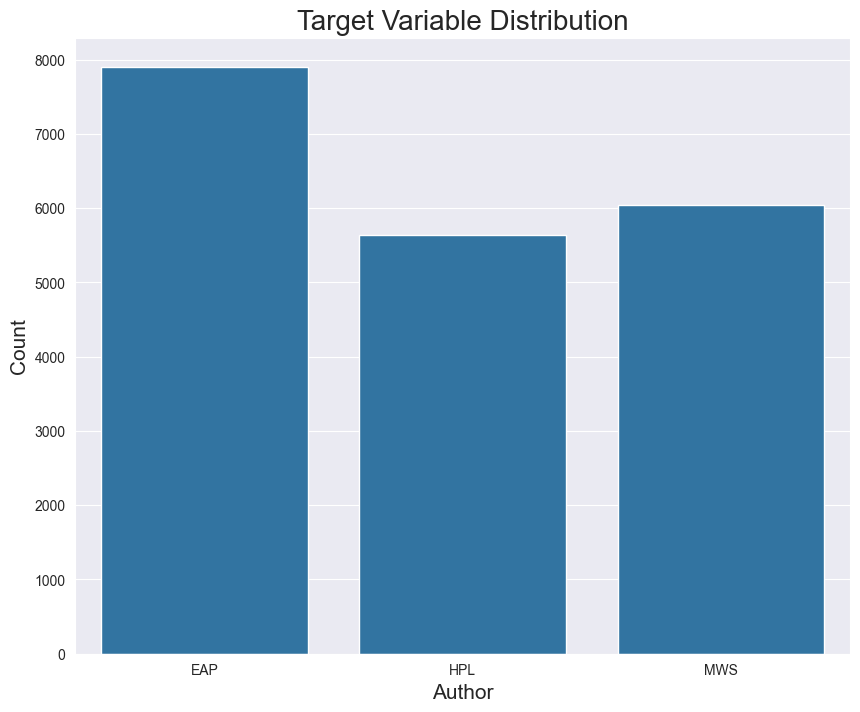

In [52]:
# display the distribution of our target variables

fig, ax = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Target Variable Distribution',fontdict={'fontsize':20})
sns.countplot(x = df['author'])
plt.xlabel('Author',fontdict={'fontsize':15})
plt.ylabel('Count',fontdict={'fontsize':15})


### Feature Extraction


In [53]:
df['no: of characters'] = df['text'].apply(lambda x: len(x))
df.head()

,id,text,author,no: of characters
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


In [54]:
df['no: of characters'].skew()

7.350785923195449

Text(0.5, 0, 'Length')

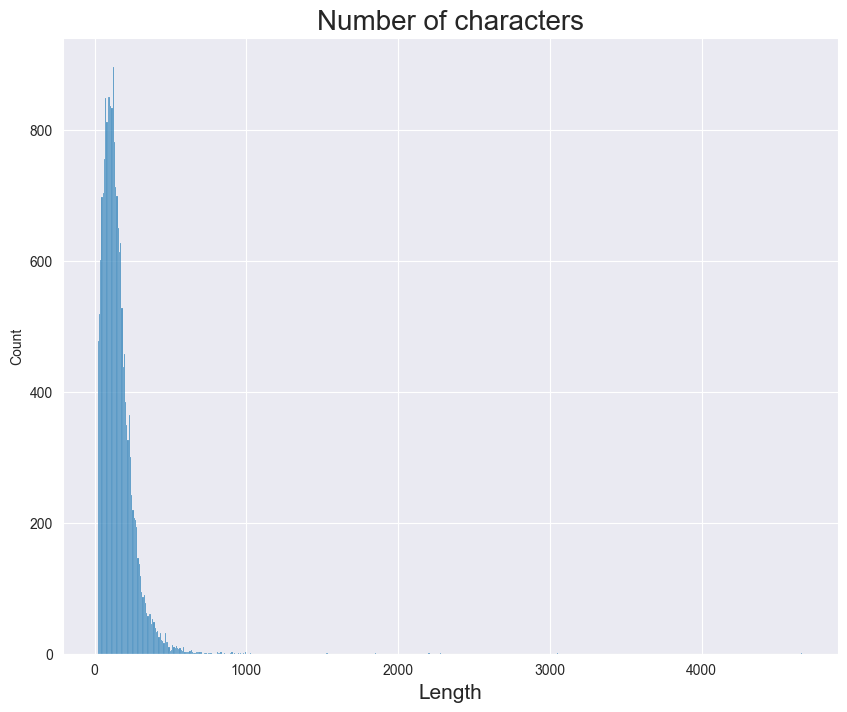

In [55]:
fig = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Number of characters' ,fontdict = {'fontsize':20} )
sns.histplot(df['no: of characters'])
plt.xlabel('Length' ,fontdict = {'fontsize':15}) 

Text(0.5, 0, 'Log(length)')

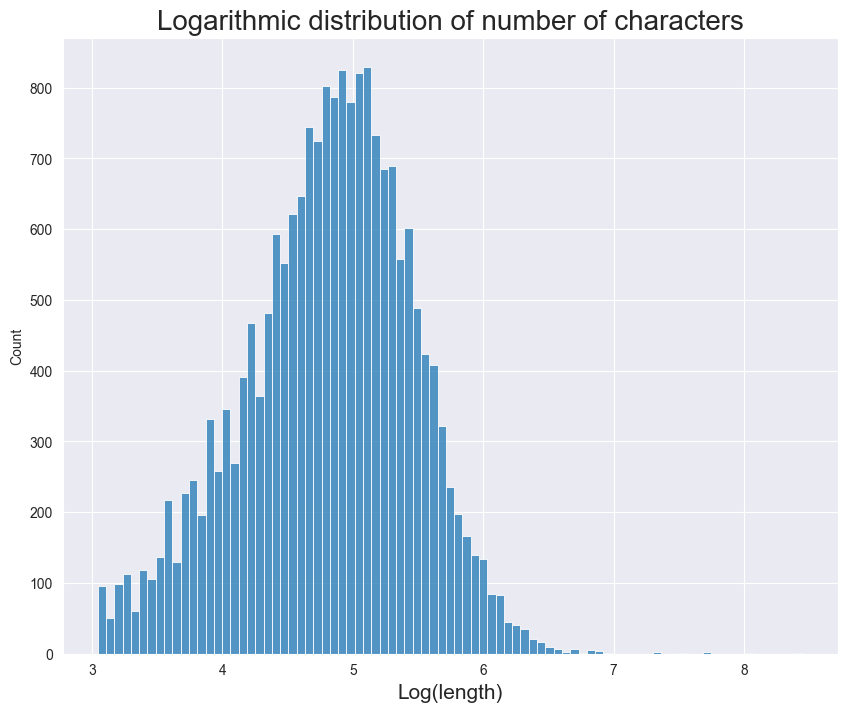

In [56]:
fig = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Logarithmic distribution of number of characters' , fontdict = {'fontsize':20})
sns.histplot(np.log(df['no: of characters']))
plt.xlabel('Log(length)',fontdict={'fontsize':15})

Text(0.5, 0, 'Length of words')

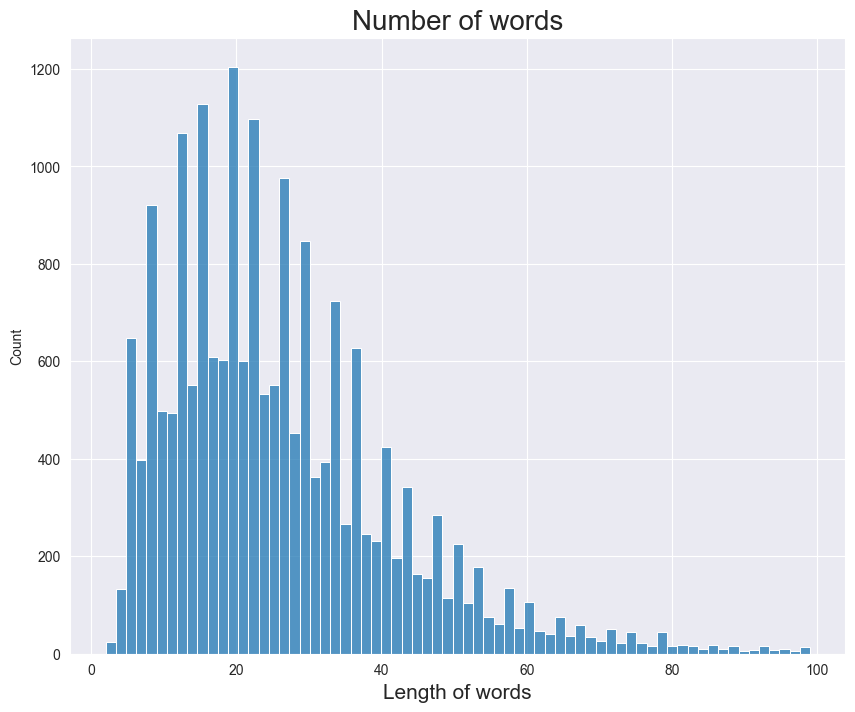

In [57]:
fig = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Number of words',fontdict={'fontsize':20})
sns.histplot(df[df['text'].str.split().map(lambda x: len(x)) < 100]['text'].str.split().map(lambda x: len(x)))
plt.xlabel('Length of words' ,fontdict={'fontsize':15})

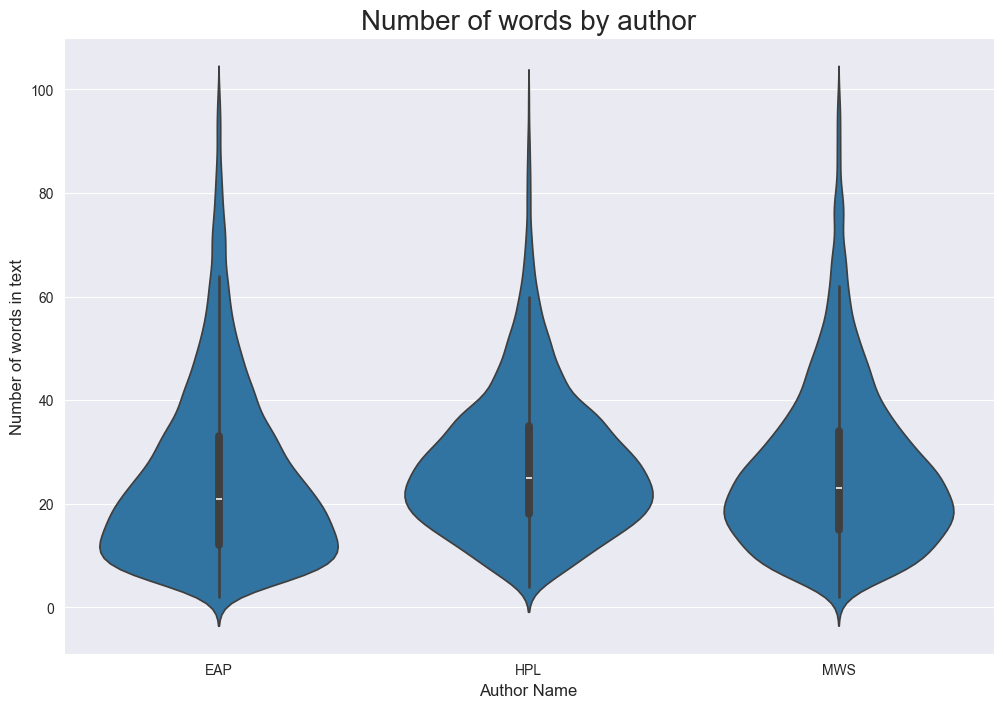

In [58]:

plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.violinplot(x='author', y=df[df['text'].str.split().map(lambda x:len(x))<100]['text'].str.split().map(lambda x:len(x)), data=df)
plt.xlabel('Author Name', fontdict = {'fontsize':12})
plt.ylabel('Number of words in text', fontdict = {'fontsize':12})
plt.title("Number of words by author", fontdict = {'fontsize':20})
plt.show()

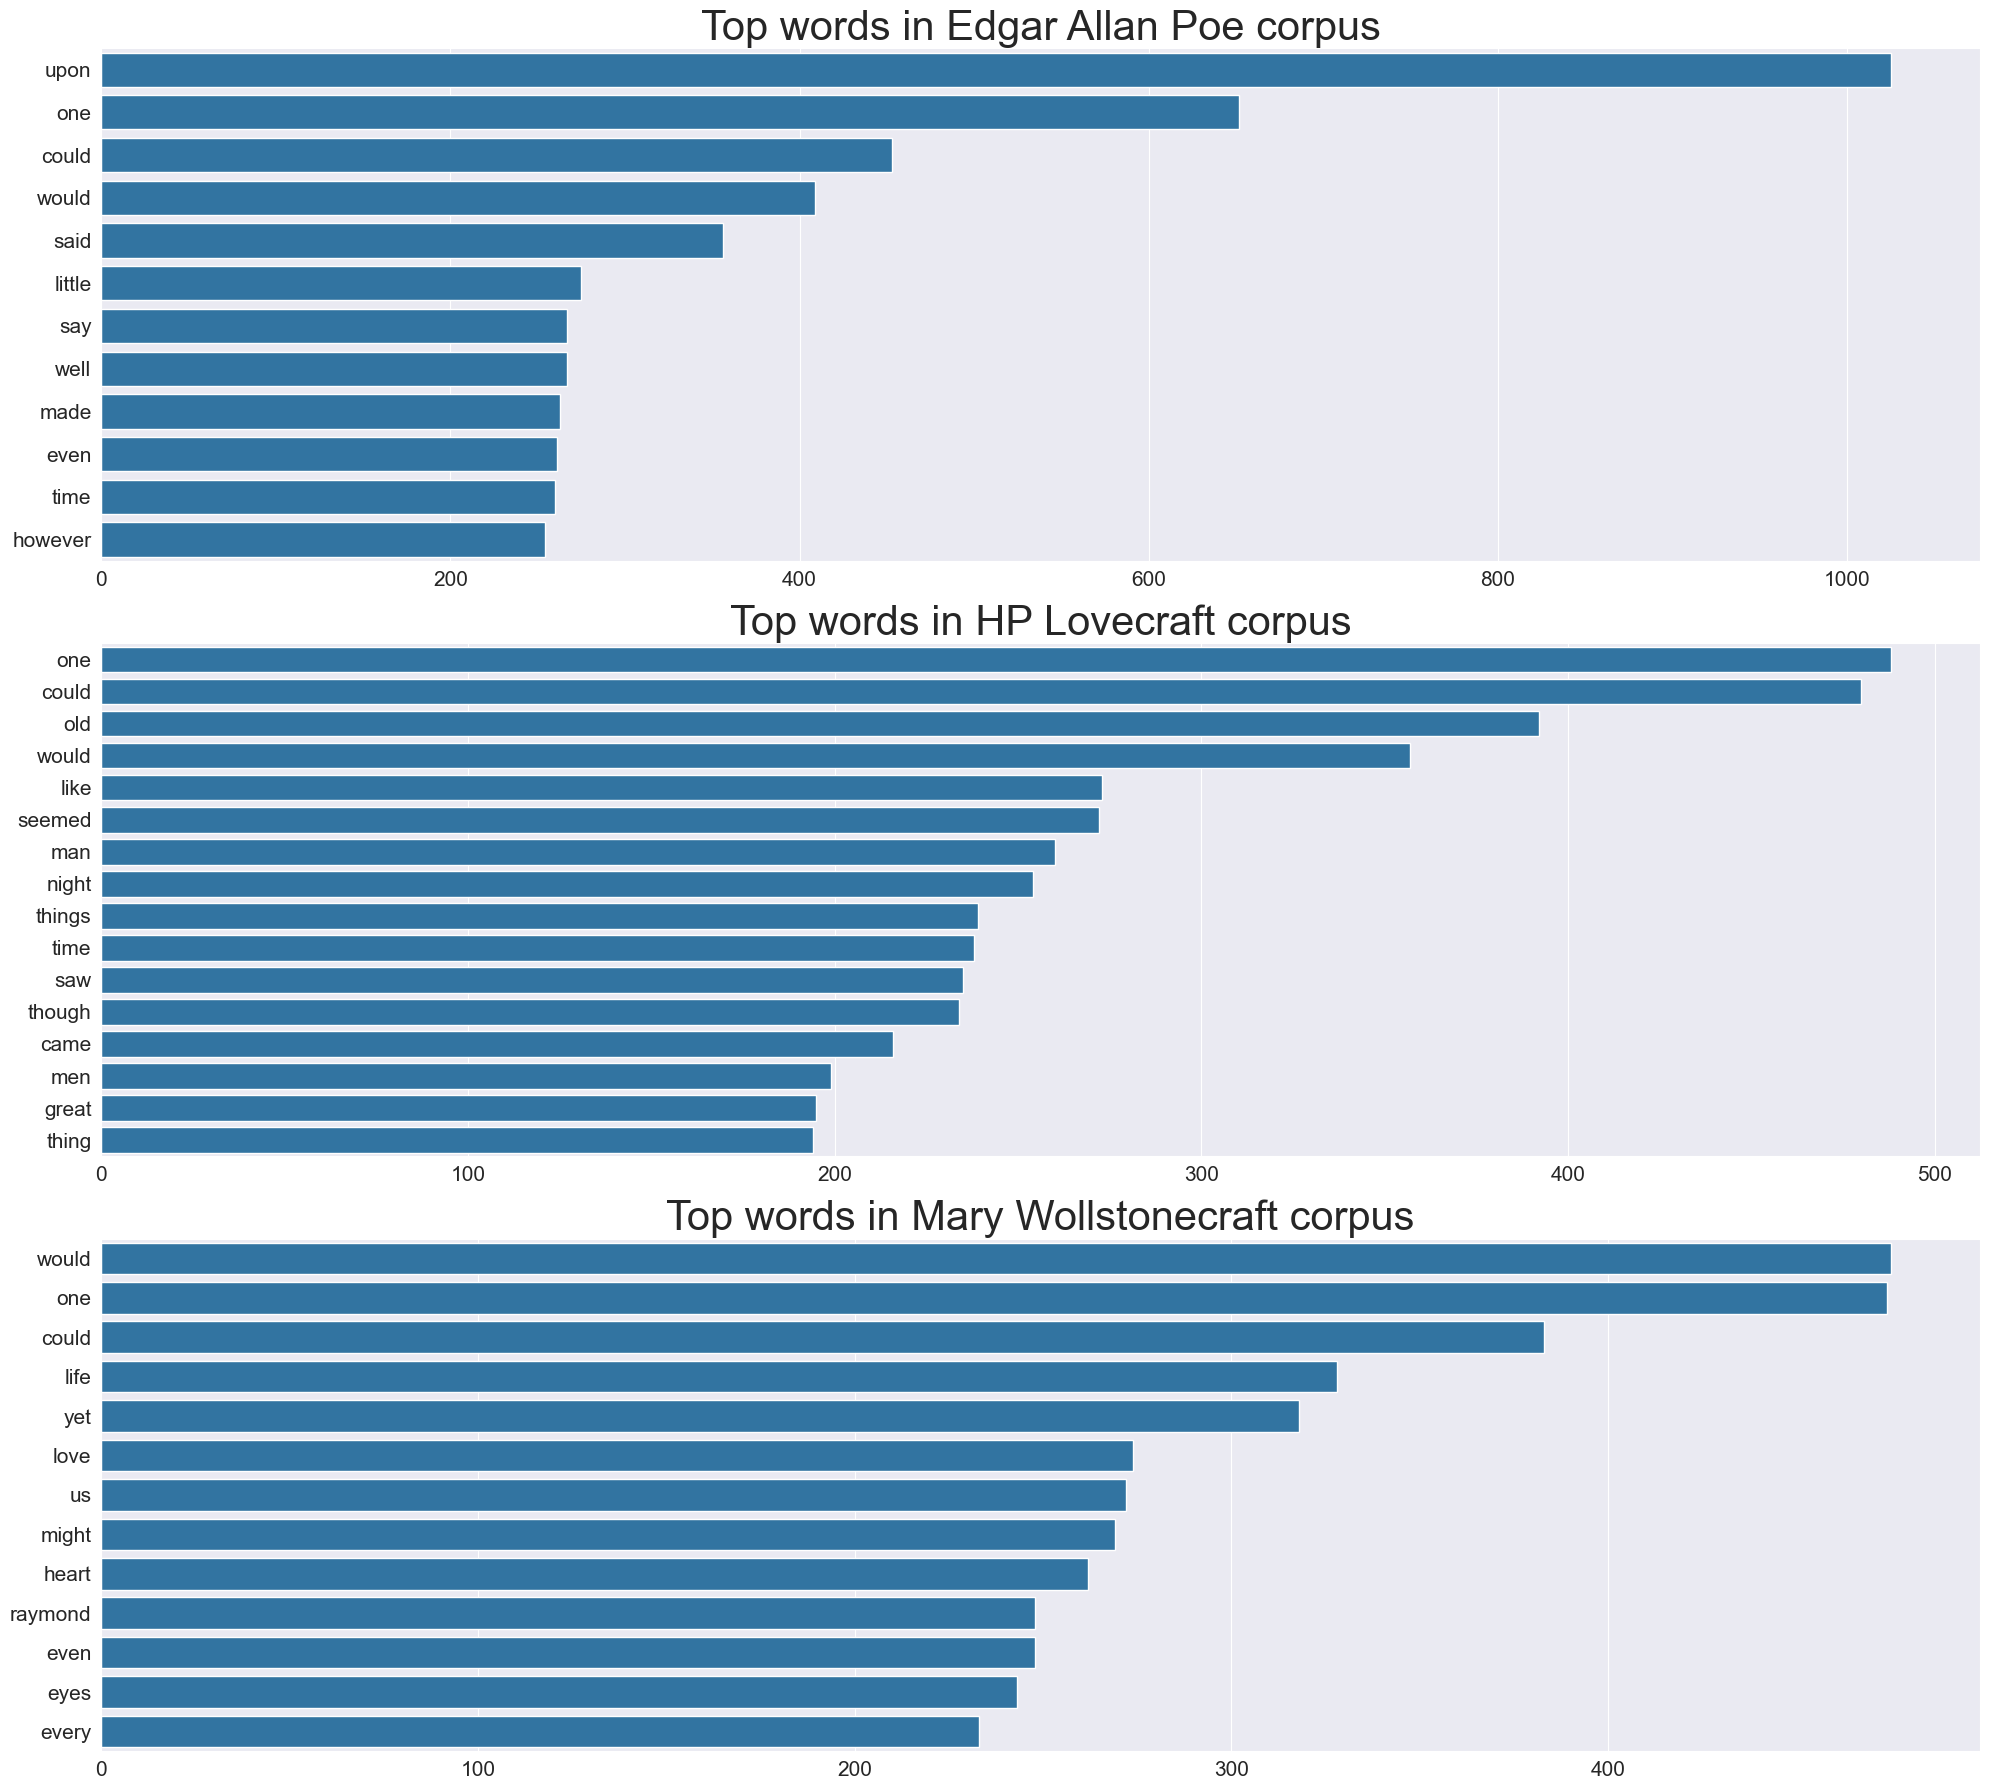

In [59]:
warnings.filterwarnings("ignore")
from collections import Counter

eap = df[df['author']=='EAP']
hpl = df[df['author']=='HPL']
mws = df[df['author']=='MWS']

def sub_clean(text):

  text = text.lower()
  text = re.sub('[^a-z\.\s]','',text)
  text = re.sub('\.',' ',text)

  return text
eap['text'] = eap['text'].apply(lambda x: sub_clean(x))
hpl['text'] = hpl['text'].apply(lambda x: sub_clean(x))
mws['text'] = mws['text'].apply(lambda x :sub_clean(x))


stop = set(stopwords.words('english'))

fig , axes = plt.subplots(3,1,figsize=(20,18))

title = ['Top words in Edgar Allan Poe corpus' , 'Top words in HP Lovecraft corpus' , 'Top words in Mary Wollstonecraft corpus']

for i , data in enumerate([eap,hpl,mws]):
  ax = axes[i]
  corpus=[]
  text = data['text'].str.split()
  text = text.values.tolist()
  corpus = [word for i in text for word in i ]

  counter = Counter(corpus)
  most = counter.most_common()
  x,y = [],[]
  for word,count in most[:80]:
    if word not in stop:
      x.append(word)
      y.append(count)
  
  ax.set_title(title[i] ,fontdict={'fontsize':30})
  ax.tick_params(axis='both',labelsize=15)
  sns.barplot(x=y,y=x,ax=ax)

plt.tight_layout()
plt.show()
plt.close()
     

In [ ]:
# created a function for ngrams


def n_gram_words(corpus,n):

    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    freq_dist = [(word,sum_words[0,idx]) for word , idx in vec.vocabulary_.items()]
    freq_dist = sorted(freq_dist , key = lambda x:x[1], reverse=True)[:15]
    
    return freq_dist